In [ ]:
!pip install numba

# Importações

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Resizing
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)

from google.colab import drive
import os

from numba import cuda

import gc

from PIL import Image

In [ ]:
drive.mount('/content/drive')

# Caminho para a pasta no Drive
pasta_drive = '/content/drive/MyDrive/Dataset'

# Mude o diretório atual para a pasta do Drive
os.chdir(pasta_drive)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = '/content/drive/MyDrive/Dataset/dataset/train'
test_dir = '/content/drive/MyDrive/Dataset/dataset/test'

In [ ]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))


2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/Dataset/dataset/train'
VAL_DIR = '/content/drive/MyDrive/Dataset/dataset/valid'
TEST_DIR = '/content/drive/MyDrive/Dataset/dataset/test'
BATCH_SIZE=32

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(417, 626),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)



Found 718 images belonging to 2 classes.


In [ ]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(417, 626),batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 208 images belonging to 2 classes.


In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(417, 626),batch_size=BATCH_SIZE,
    class_mode='binary'
)
test_generator.class_indices

Found 106 images belonging to 2 classes.


{'icecream': 0, 'pizza': 1}

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
list_learn_rate = [1e-2,1e-3,1e-4]
list_batch_size = [32,64,128]
list_epochs = [5,10,15]

# Definindo modelos

AlexNet https://pt.d2l.ai/chapter_convolutional-modern/alexnet.html

In [ ]:
def create_alexnet(num_classes=1, batch_normalization = False, dropout = False):
  # Definindo a arquitetura da AlexNet
  model = tf.keras.models.Sequential()

  # Adicionando as camadas convolucionais417, 626, 3
  #model.add(tf.keras.layers.Resizing(32, 32, input_shape=(None, None, 3)))
  #model.add(tf.keras.layers.Conv2D(96, (11, 11), strides=(4, 4), input_shape=(32, 32, 3)))
  model.add(tf.keras.layers.Conv2D(96, (11, 11), strides=(4, 4), input_shape=(417, 626, 3)))
  #model.add(tf.keras.layers.Conv2D(96, (11, 11), strides=(4, 4), padding='valid'))
  if batch_normalization:
    model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

  model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same'))
  if batch_normalization:
    model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

  model.add(tf.keras.layers.Conv2D(384, (3, 3), padding='same'))
  if batch_normalization:
    model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))

  model.add(tf.keras.layers.Conv2D(384, (3, 3), padding='same'))
  if batch_normalization:
    model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))

  model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same'))
  if batch_normalization:
    model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

  # Flatten para as camadas totalmente conectadas
  model.add(tf.keras.layers.Flatten())

  # Adicionando as camadas totalmente conectadas
  model.add(tf.keras.layers.Dense(4096))
  if batch_normalization:
    model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  if dropout:
    model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(4096))
  if batch_normalization:
    model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  if dropout:
    model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(num_classes, activation='sigmoid'))

  return model  # Número de classes para classificação
  """
    model_alex = Sequential([
        Resizing(224, 224, input_shape=(None, None, 3)),  # Add Resizing layer
        Conv2D(96, (11, 11), strides=(4, 4), activation='relu'),
        MaxPooling2D((3, 3), strides=(2, 2)),
        Conv2D(256, (5, 5), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((3, 3), strides=(2, 2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Dense(4096, activation='relu'),
        Dense(nodes, activation='softmax')
    ])
      return model_alex
    """





### VGG16

In [ ]:
def create_vgg16(num_classes=1, batch_normalization = False, dropout = False):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Resizing(128, 128, input_shape=(None, None, 3)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(128, 128, 3)))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(128, 128, 3)))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Bloco 2
    model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same'))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same'))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Bloco 3
    model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same'))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same'))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same'))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Bloco 4
    model.add(tf.keras.layers.Conv2D(512, (3, 3), padding='same'))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(512, (3, 3), padding='same'))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(512, (3, 3), padding='same'))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Bloco 5
    model.add(tf.keras.layers.Conv2D(512, (3, 3), padding='same'))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(512, (3, 3), padding='same'))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(512, (3, 3), padding='same'))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Camada densa
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(4096))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    if dropout:
      model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(4096))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    if dropout:
      model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(num_classes, activation='sigmoid'))

    return model

In [ ]:
def retornarAnalise(model):
  # Fazer previsões no conjunto de teste
  predictions = model.predict(test_generator).ravel()

  # Converter as previsões para classes (0 ou 1 em um problema binário)
  predicted_classes = (predictions > 0.5).astype('int32')
  print("predicted_classes ",predictions)
  #predicted_classes = np.argmax(predictions, axis=1)
  # Obter rótulos verdadeiros do conjunto de teste
  true_classes = test_generator.classes
  confusion_mtx = confusion_matrix(true_classes, predicted_classes)

  # Imprimir a matriz de confusão
  print("Matriz de Confusão:")
  print(confusion_mtx)
  report = classification_report(true_classes, predicted_classes)
  return report

In [ ]:
print(test_generator.classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


# Outra rede neural de teste

In [ ]:
model = tf.keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(417, 626, 3)),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', input_shape=(417, 626, 3)),
    layers.MaxPool2D((2, 2)),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=1,
    validation_steps=len(val_generator),
    validation_data=val_generator
)

In [ ]:
print(retornarAnalise(model))

# Testes AlexNet

##AlexNet Parte 1

In [ ]:
learn_rate_history = []
learn_rate_history_test = []

#for learn_rate in list_learn_rate:

for learn_rate in list_learn_rate:
  model_alexnet = create_alexnet()
  model_alexnet.compile(optimizer=SGD(learning_rate=learn_rate),
                loss='binary_crossentropy',
      metrics=['accuracy'])
  learn_rate_history.append(model_alexnet.fit(train_generator, steps_per_epoch=len(train_generator), epochs=5,
      validation_steps=len(val_generator),
      validation_data=val_generator))
  learn_rate_history_test = model_alexnet.evaluate(test_generator, verbose=5)
  print(retornarAnalise(model_alexnet))
#learn_rate_history_test = model_alexnet.evaluate(test_generator, verbose=5)

Epoch 1/5
23/23 [==============================] - 58s 2s/step - loss: 0.6863 - accuracy: 0.5989 - val_loss: 0.6770 - val_accuracy: 0.5481
Epoch 2/5
23/23 [==============================] - 51s 2s/step - loss: 0.6599 - accuracy: 0.6323 - val_loss: 0.6976 - val_accuracy: 0.4567
Epoch 3/5
23/23 [==============================] - 54s 2s/step - loss: 0.6232 - accuracy: 0.6838 - val_loss: 0.6106 - val_accuracy: 0.6154
Epoch 4/5
23/23 [==============================] - 50s 2s/step - loss: 0.5877 - accuracy: 0.6978 - val_loss: 0.5272 - val_accuracy: 0.7885
Epoch 5/5
4/4 [==============================] - 2s 471ms/step
predicted_classes  [0.05570111 0.5109367  0.3719101  0.48405996 0.24972038 0.19170702
 0.69790983 0.11406012 0.11794568 0.16233061 0.5382819  0.03981597
 0.28338677 0.7091253  0.67503667 0.33000392 0.3046422  0.16515817
 0.16576657 0.26319546 0.2429471  0.04668667 0.07668144 0.1836208
 0.2724422  0.03957558 0.39546633 0.39150667 0.26440972 0.30852437
 0.06352831 0.05740581 0.729

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
23/23 [==============================] - 51s 2s/step - loss: 0.6927 - accuracy: 0.5390 - val_loss: 0.6923 - val_accuracy: 0.5481
Epoch 2/5
23/23 [==============================] - 50s 2s/step - loss: 0.6923 - accuracy: 0.5390 - val_loss: 0.6921 - val_accuracy: 0.5481
Epoch 3/5
23/23 [==============================] - 50s 2s/step - loss: 0.6921 - accuracy: 0.5292 - val_loss: 0.6919 - val_accuracy: 0.5433
Epoch 4/5
23/23 [==============================] - 64s 3s/step - loss: 0.6920 - accuracy: 0.5390 - val_loss: 0.6917 - val_accuracy: 0.5433
Epoch 5/5
4/4 [==============================] - 1s 227ms/step
predicted_classes  [0.49776956 0.49723873 0.49193537 0.4905998  0.49247116 0.4930947
 0.49491856 0.49325952 0.49519995 0.49324003 0.49582154 0.49154657
 0.4916681  0.4955718  0.49669075 0.4927675  0.49454275 0.49336314
 0.4960109  0.49603343 0.49231157 0.49702123 0.49533886 0.49335298
 0.49395356 0.4974554  0.493245   0.49362502 0.49402782 0.49524942
 0.49199152 0.49758923 0.493

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


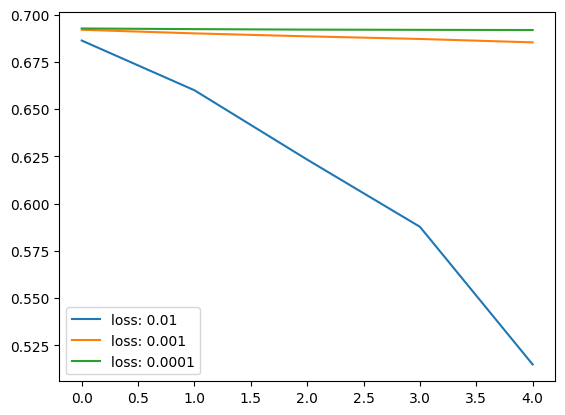

In [ ]:
import matplotlib.pyplot as plt

for i in range (len(learn_rate_history)):
  plt.plot(learn_rate_history[i].history["loss"],label=f'loss: {list_learn_rate[i]}')
  plt.legend()



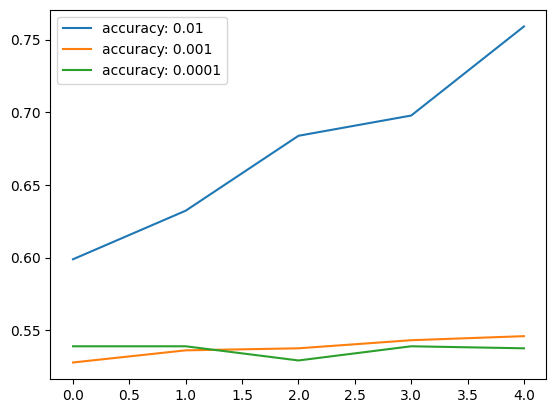

In [ ]:
for i in range (len(learn_rate_history)):
  plt.plot(learn_rate_history[i].history["accuracy"],label=f'accuracy: {list_learn_rate[i]}')
  plt.legend()

In [ ]:
accuracies = [history.history["accuracy"] for history in learn_rate_history]
best_accuracy_index = max(range(len(accuracies)), key=lambda i: accuracies[i][-1])
best_learn_rate_for_accuracy = list_learn_rate[best_accuracy_index]

print(f"Melhor taxa de aprendizado para a maior accuracy: {best_learn_rate_for_accuracy}")


Melhor taxa de aprendizado para a maior accuracy: 0.01


In [ ]:
history_batchsize = []
history_test_batchsize = []
best_accuracy = 0
best_learn_rate_for_accuracy = 0.01
best_batch_size = None
contador = 0

for batch_size in list_batch_size:
  model_alexnet = create_alexnet()
  model_alexnet.compile(optimizer=SGD(learning_rate=best_learn_rate_for_accuracy),
                loss='binary_crossentropy',
      metrics=['accuracy'])
  history_batchsize.append(model_alexnet.fit(train_generator, batch_size=batch_size, steps_per_epoch=len(train_generator), epochs=5,
      validation_steps=len(val_generator),
      validation_data=val_generator))
  history_test_batchsize = model_alexnet.evaluate(test_generator, verbose=5)

  print(retornarAnalise(model_alexnet))


Epoch 1/5
23/23 [==============================] - 58s 2s/step - loss: 0.6886 - accuracy: 0.5501 - val_loss: 0.6792 - val_accuracy: 0.7308
Epoch 2/5
23/23 [==============================] - 50s 2s/step - loss: 0.6701 - accuracy: 0.6295 - val_loss: 0.6397 - val_accuracy: 0.7981
Epoch 3/5
23/23 [==============================] - 51s 2s/step - loss: 0.6412 - accuracy: 0.6699 - val_loss: 0.6308 - val_accuracy: 0.7404
Epoch 4/5
23/23 [==============================] - 49s 2s/step - loss: 0.6025 - accuracy: 0.7187 - val_loss: 0.5634 - val_accuracy: 0.7308
Epoch 5/5
4/4 [==============================] - 1s 213ms/step
predicted_classes  [0.30821437 0.19669354 0.7072524  0.5646602  0.91088426 0.81781226
 0.6205606  0.57333314 0.23821463 0.6002675  0.7809189  0.6977451
 0.29780775 0.3265786  0.50048953 0.18844293 0.64991057 0.2725033
 0.18673816 0.86780035 0.91076595 0.9065204  0.17938569 0.75019294
 0.6192057  0.37039283 0.8213296  0.72871304 0.3408441  0.37090668
 0.33289048 0.48779157 0.1368

In [ ]:
print(f"Melhor batchsize para a maior accuracy: {best_batch_size}")

Melhor batchsize para a maior accuracy: 128


## AlexNet parte 2

In [ ]:
best_learn_rate_for_accuracy = 0.01
best_batch_size = 32

In [ ]:
epochs_history = []
epochs_history_test = []

best_accuracy = 0
best_epochs = None
contador = 0

for epoch in list_epochs:
  model_alexnet = create_alexnet()
  model_alexnet.compile(optimizer=SGD(learning_rate=best_learn_rate_for_accuracy),
                loss='binary_crossentropy',
      metrics=['accuracy'])
  epochs_history.append(model_alexnet.fit(train_generator, batch_size=best_batch_size, epochs=epoch, steps_per_epoch=len(train_generator),
      validation_steps=len(val_generator),
      validation_data=val_generator))
  epochs_history_test = model_alexnet.evaluate(test_generator, verbose=5)

  print(retornarAnalise(model_alexnet))

Epoch 1/5
23/23 [==============================] - 59s 2s/step - loss: 0.6853 - accuracy: 0.5543 - val_loss: 0.6765 - val_accuracy: 0.5481
Epoch 2/5
23/23 [==============================] - 49s 2s/step - loss: 0.6551 - accuracy: 0.6560 - val_loss: 0.6267 - val_accuracy: 0.6010
Epoch 3/5
23/23 [==============================] - 49s 2s/step - loss: 0.6416 - accuracy: 0.6407 - val_loss: 0.6498 - val_accuracy: 0.5673
Epoch 4/5
23/23 [==============================] - 49s 2s/step - loss: 0.6724 - accuracy: 0.5571 - val_loss: 0.6855 - val_accuracy: 0.4567
Epoch 5/5
4/4 [==============================] - 1s 221ms/step
predicted_classes  [0.5168616  0.49405754 0.583264   0.55050164 0.65024966 0.60214186
 0.5422851  0.5489066  0.5169125  0.52811605 0.5795301  0.57962745
 0.5062898  0.5037418  0.5302957  0.49151278 0.5734948  0.5223619
 0.48324493 0.61350656 0.64820534 0.646552   0.48635858 0.5707268
 0.5783269  0.5166958  0.6055629  0.5922045  0.50478023 0.5007014
 0.5218965  0.49085143 0.48251

In [ ]:
best_learn_rate_for_accuracy = 0.01
best_batch_size = 32
best_epochs = 15

In [ ]:
dropout_history = []
dropout_history_test = []

model_alexnet = create_alexnet(dropout = True)
model_alexnet.compile(optimizer=SGD(learning_rate=best_learn_rate_for_accuracy),
                loss='binary_crossentropy',
      metrics=['accuracy'])
dropout_history.append(model_alexnet.fit(train_generator, batch_size=best_batch_size, epochs=best_epochs, steps_per_epoch=len(train_generator),
      validation_steps=len(val_generator),
      validation_data=val_generator))
dropout_history_test = model_alexnet.evaluate(test_generator, verbose=5)

print(retornarAnalise(model_alexnet))

Epoch 1/15
23/23 [==============================] - 58s 2s/step - loss: 0.6898 - accuracy: 0.5432 - val_loss: 0.6798 - val_accuracy: 0.5481
Epoch 2/15
23/23 [==============================] - 54s 2s/step - loss: 0.6778 - accuracy: 0.5905 - val_loss: 0.6582 - val_accuracy: 0.5481
Epoch 3/15
23/23 [==============================] - 49s 2s/step - loss: 0.6397 - accuracy: 0.6755 - val_loss: 0.5772 - val_accuracy: 0.7740
Epoch 4/15
23/23 [==============================] - 49s 2s/step - loss: 0.6342 - accuracy: 0.6727 - val_loss: 0.5239 - val_accuracy: 0.7981
Epoch 5/15
23/23 [==============================] - 49s 2s/step - loss: 0.5878 - accuracy: 0.7214 - val_loss: 0.4975 - val_accuracy: 0.8173
Epoch 6/15
23/23 [==============================] - 49s 2s/step - loss: 0.5256 - accuracy: 0.7786 - val_loss: 0.5256 - val_accuracy: 0.7644
Epoch 7/15
23/23 [==============================] - 48s 2s/step - loss: 0.5060 - accuracy: 0.7688 - val_loss: 0.4147 - val_accuracy: 0.8269
Epoch 8/15
23/23 [==

In [ ]:
batch_normalization_history = []
batch_normalization_history_test = []

model_alexnet = create_alexnet(dropout = True, batch_normalization = True)
model_alexnet.compile(optimizer=SGD(learning_rate=best_learn_rate_for_accuracy),
                loss='binary_crossentropy',
      metrics=['accuracy'])
batch_normalization_history.append(model_alexnet.fit(train_generator, batch_size=best_batch_size, epochs=best_epochs, steps_per_epoch=len(train_generator),
      validation_steps=len(val_generator),
      validation_data=val_generator))
batch_normalization_history_test = model_alexnet.evaluate(test_generator, verbose=5)

print(retornarAnalise(model_alexnet))

Epoch 1/15
23/23 [==============================] - 56s 2s/step - loss: 0.4732 - accuracy: 0.7994 - val_loss: 0.7238 - val_accuracy: 0.5481
Epoch 2/15
23/23 [==============================] - 53s 2s/step - loss: 0.3485 - accuracy: 0.8677 - val_loss: 0.9555 - val_accuracy: 0.5481
Epoch 3/15
23/23 [==============================] - 52s 2s/step - loss: 0.3469 - accuracy: 0.8593 - val_loss: 1.3129 - val_accuracy: 0.5481
Epoch 4/15
23/23 [==============================] - 53s 2s/step - loss: 0.2345 - accuracy: 0.9109 - val_loss: 1.5323 - val_accuracy: 0.5481
Epoch 5/15
23/23 [==============================] - 54s 2s/step - loss: 0.2195 - accuracy: 0.9150 - val_loss: 1.6565 - val_accuracy: 0.5481
Epoch 6/15
23/23 [==============================] - 50s 2s/step - loss: 0.1999 - accuracy: 0.9234 - val_loss: 1.5978 - val_accuracy: 0.5481
Epoch 7/15
23/23 [==============================] - 52s 2s/step - loss: 0.1797 - accuracy: 0.9318 - val_loss: 2.2482 - val_accuracy: 0.5481
Epoch 8/15
23/23 [==

# Testes VGG16

## VGG16 Parte 1

In [ ]:
learn_rate_history = []
learn_rate_history_test = []
for learn_rate in list_learn_rate:
  model_vgg16 = create_vgg16()
  model_vgg16.compile(optimizer=SGD(learning_rate=learn_rate),
                loss='binary_crossentropy',
      metrics=['accuracy'])
  learn_rate_history.append(model_vgg16.fit(train_generator, epochs=5, steps_per_epoch=len(train_generator),
      validation_steps=len(val_generator),
      validation_data=val_generator))
  learn_rate_history_test = model_vgg16.evaluate(test_generator, verbose=5)

  print(retornarAnalise(model_vgg16))

Epoch 1/5
23/23 [==============================] - 62s 2s/step - loss: 0.6927 - accuracy: 0.5418 - val_loss: 0.6919 - val_accuracy: 0.5481
Epoch 2/5
23/23 [==============================] - 49s 2s/step - loss: 0.6918 - accuracy: 0.5446 - val_loss: 0.6911 - val_accuracy: 0.5481
Epoch 3/5
23/23 [==============================] - 49s 2s/step - loss: 0.6910 - accuracy: 0.5446 - val_loss: 0.6905 - val_accuracy: 0.5481
Epoch 4/5
23/23 [==============================] - 49s 2s/step - loss: 0.6906 - accuracy: 0.5446 - val_loss: 0.6899 - val_accuracy: 0.5481
Epoch 5/5
4/4 [==============================] - 1s 232ms/step
predicted_classes  [0.47675434 0.47635362 0.4771628  0.47741917 0.47727206 0.4771235
 0.47740346 0.47755823 0.47687733 0.47771454 0.47798455 0.47713485
 0.47734854 0.47724262 0.47714353 0.4763106  0.47736603 0.4769335
 0.47699177 0.47791004 0.4776237  0.4779136  0.4767293  0.47780538
 0.4771919  0.47723055 0.47694185 0.47708705 0.47787607 0.47771236
 0.47668537 0.4779083  0.4762

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
23/23 [==============================] - 53s 2s/step - loss: 0.6931 - accuracy: 0.5348 - val_loss: 0.6930 - val_accuracy: 0.5481
Epoch 2/5
23/23 [==============================] - 64s 3s/step - loss: 0.6929 - accuracy: 0.5446 - val_loss: 0.6929 - val_accuracy: 0.5481
Epoch 3/5
23/23 [==============================] - 49s 2s/step - loss: 0.6928 - accuracy: 0.5446 - val_loss: 0.6927 - val_accuracy: 0.5481
Epoch 4/5
23/23 [==============================] - 50s 2s/step - loss: 0.6927 - accuracy: 0.5446 - val_loss: 0.6926 - val_accuracy: 0.5481
Epoch 5/5
4/4 [==============================] - 1s 230ms/step
predicted_classes  [0.49670127 0.49665764 0.4966116  0.49681288 0.49675086 0.4965412
 0.4967824  0.49659583 0.4968508  0.49672568 0.49677333 0.49673182
 0.4967551  0.4968136  0.49653974 0.4967444  0.49700645 0.49669862
 0.49677157 0.49683982 0.4970129  0.49693802 0.49670726 0.49699774
 0.49690905 0.49663523 0.49672744 0.496926   0.49690095 0.4969167
 0.49682066 0.4967848  0.4967

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
23/23 [==============================] - 51s 2s/step - loss: 0.6931 - accuracy: 0.5446 - val_loss: 0.6931 - val_accuracy: 0.5481
Epoch 2/5
23/23 [==============================] - 49s 2s/step - loss: 0.6931 - accuracy: 0.5446 - val_loss: 0.6930 - val_accuracy: 0.5481
Epoch 3/5
23/23 [==============================] - 49s 2s/step - loss: 0.6931 - accuracy: 0.5446 - val_loss: 0.6930 - val_accuracy: 0.5481
Epoch 4/5
23/23 [==============================] - 49s 2s/step - loss: 0.6930 - accuracy: 0.5446 - val_loss: 0.6930 - val_accuracy: 0.5481
Epoch 5/5
4/4 [==============================] - 1s 219ms/step
predicted_classes  [0.499297   0.49908942 0.49916634 0.499162   0.49912143 0.49926466
 0.49922615 0.49904862 0.49921358 0.49925765 0.49917495 0.4991948
 0.4991487  0.499388   0.49927393 0.49905813 0.4992438  0.4992299
 0.4990771  0.49934474 0.49947685 0.49917132 0.49921682 0.49912944
 0.49914232 0.4990517  0.49917868 0.49914092 0.49908346 0.49924013
 0.4992377  0.49908584 0.4991

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
history = []
history_test = []
model_vgg16 = create_vgg16()
model_vgg16.compile(optimizer=SGD(learning_rate=0.1),
                loss='binary_crossentropy',
      metrics=['accuracy'])
history.append(model_vgg16.fit(train_generator, epochs=5, steps_per_epoch=len(train_generator),
      validation_steps=len(val_generator),
      validation_data=val_generator))
history_test = model_vgg16.evaluate(test_generator, verbose=5)

print(retornarAnalise(model_vgg16))

Epoch 1/5
23/23 [==============================] - 52s 2s/step - loss: 0.6914 - accuracy: 0.5446 - val_loss: 0.6885 - val_accuracy: 0.5481
Epoch 2/5
23/23 [==============================] - 50s 2s/step - loss: 0.6887 - accuracy: 0.5446 - val_loss: 0.6883 - val_accuracy: 0.5481
Epoch 3/5
23/23 [==============================] - 49s 2s/step - loss: 0.6885 - accuracy: 0.5446 - val_loss: 0.6777 - val_accuracy: 0.5481
Epoch 4/5
23/23 [==============================] - 49s 2s/step - loss: 0.6881 - accuracy: 0.5446 - val_loss: 0.6821 - val_accuracy: 0.5481
Epoch 5/5
4/4 [==============================] - 1s 230ms/step
predicted_classes  [0.48657623 0.48627666 0.48650736 0.4853996  0.4861472  0.48609942
 0.48743352 0.48606732 0.4796493  0.4855094  0.48735863 0.48567995
 0.48657623 0.48629674 0.48553813 0.48711395 0.4865607  0.4854674
 0.4862943  0.48678792 0.48711538 0.48645213 0.48747453 0.48636955
 0.48637506 0.4852623  0.48677325 0.4862982  0.48668703 0.48635194
 0.48769763 0.48719367 0.487

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
history = []
history_test = []
model_vgg16 = create_vgg16(batch_normalization = True, dropout = True)
model_vgg16.compile(optimizer=SGD(learning_rate=0.1),
                loss='binary_crossentropy',
      metrics=['accuracy'])
history.append(model_vgg16.fit(train_generator, epochs=10, steps_per_epoch=len(train_generator),
      validation_steps=len(val_generator),
      validation_data=val_generator))
history_test = model_vgg16.evaluate(test_generator, verbose=5)

print(retornarAnalise(model_vgg16))

Epoch 1/10
23/23 [==============================] - 62s 2s/step - loss: 2.9872 - accuracy: 0.5780 - val_loss: 152.2575 - val_accuracy: 0.5433
Epoch 2/10
23/23 [==============================] - 51s 2s/step - loss: 2.7148 - accuracy: 0.6142 - val_loss: 2906.6108 - val_accuracy: 0.4712
Epoch 3/10
23/23 [==============================] - 49s 2s/step - loss: 1.6250 - accuracy: 0.6838 - val_loss: 300.8581 - val_accuracy: 0.4904
Epoch 4/10
23/23 [==============================] - 49s 2s/step - loss: 3.8138 - accuracy: 0.5877 - val_loss: 452.2959 - val_accuracy: 0.4519
Epoch 5/10
23/23 [==============================] - 49s 2s/step - loss: 1.5636 - accuracy: 0.7284 - val_loss: 213.0786 - val_accuracy: 0.5337
Epoch 6/10
23/23 [==============================] - 49s 2s/step - loss: 1.3770 - accuracy: 0.7618 - val_loss: 156.7262 - val_accuracy: 0.5433
Epoch 7/10
23/23 [==============================] - 49s 2s/step - loss: 1.7960 - accuracy: 0.7479 - val_loss: 295.1166 - val_accuracy: 0.6587
Epoch

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_vgg16 = create_vgg16()
model_vgg16.compile(optimizer=SGD(learning_rate=0.1),
                loss='binary_crossentropy',
      metrics=['accuracy'])
learn_rate_history.append(model_vgg16.fit(train_generator, epochs=5, steps_per_epoch=len(train_generator),
      validation_steps=len(val_generator),
      validation_data=val_generator))
learn_rate_history_test = model_vgg16.evaluate(test_generator, verbose=5)

print(retornarAnalise(model_vgg16))